## Random Search

# Feature Engineering

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy.stats.mstats import winsorize

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos.  
Se usa como índice building_id para train_values y train_labels  

In [3]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [4]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

## Información de los datasets

In [5]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [6]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [7]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


# Aplicamos transformaciones

In [8]:
# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion

In [9]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# this function takes a dataframe as input and
# returns a modified version thereof
def select_columns_iloc(input_df,range_columns):
    output_df = input_df.iloc[:,range_columns[0]:range_columns[1]]
    return output_df

def drop_columns(input_df,columns):
    output_df = input_df.copy()
    for column_name in columns:
        output_df = output_df.drop(labels=column_name,axis=1)
    return output_df

def winsorize_columns(input_df,columns_to_winsorize,ranges_winsorize):
    for i in range(len(columns_to_winsorize)):
        columna_winsorize = winsorize(input_df[columns_to_winsorize[i]],ranges_winsorize[i])
        input_df[columns_to_winsorize[i]] = columna_winsorize
    return input_df

def get_dummies_transform(input_df):
    return pd.get_dummies(input_df)

#auxiliar
def nombre_nueva_mean_col(col_name,damage_grade):
    damage_names = {1:'low',2:'medium',3:'high'}
    return 'mean_'+damage_names[damage_grade]+'_damage_'+col_name

#generalizar para una columna
def agregar_col_mean_daño_por_columna(input_df,labels_df,col_name,damage_grade):
    """Agrega una columna llamada mean_damage_'col_name' con el mean damage para el daño 'damage_grade'"""
    work_df = input_df[[col_name]].copy()
    work_df = work_df.join(labels_df,on='building_id',how='inner')
    work_df['count_damage_i'] = work_df['damage_grade'] == damage_grade
    new_col_name = nombre_nueva_mean_col(col_name,damage_grade)
    input_df[new_col_name] = work_df.groupby(col_name).transform('mean')['count_damage_i']
    return input_df


In [10]:
#Ajustes iniciales
pipeline_inicial = Pipeline([
    ("drop_has_sec_variants", FunctionTransformer(select_columns_iloc,kw_args={'range_columns':(0,28)})),
    ("drop_plan_config", FunctionTransformer(drop_columns,kw_args={'columns': ['plan_configuration']})),
    ("winsorize", FunctionTransformer(winsorize_columns,kw_args={'columns_to_winsorize': ['age','area_percentage','height_percentage'],
                                                                'ranges_winsorize': [(0,0.03),(0,0.03),(0,0.06)]})),
])
# Probar al final si sacarlos obtengo mejor score.

In [11]:
#Mean col geo
steps_daños = []
for geo_level_id in range(1,4):
    for damage_grade in range(1,4):
        nombre_step = 'add_damage_'+str(damage_grade)+'_geo_'+str(geo_level_id)
        args = {'labels_df': train_labels,'col_name': 'geo_level_'+str(geo_level_id)+'_id','damage_grade':damage_grade}
        steps_daños.append((nombre_step,FunctionTransformer(agregar_col_mean_daño_por_columna,kw_args=args)))

In [12]:
pipeline_daños = Pipeline(steps=steps_daños)
#pipeline_daños

In [13]:
#Mean col area
steps_area = []
for damage_grade in range(1,4):
    nombre_step = 'add_damage_'+str(damage_grade)+'_height'
    args = {'labels_df': train_labels,'col_name': 'area_percentage','damage_grade':damage_grade}
    steps_area.append((nombre_step,FunctionTransformer(agregar_col_mean_daño_por_columna,kw_args=args)))

In [14]:
pipeline_area= Pipeline(steps=steps_area)

### Aplico transformaciones

In [15]:
train_values_transformado = pipeline_inicial.fit_transform(train_values)

In [16]:
train_values_transformado = pipeline_daños.fit_transform(train_values_transformado)

In [17]:
train_values_transformado = pipeline_area.fit_transform(train_values_transformado)

In [18]:
train_values_transformado = pd.get_dummies(train_values_transformado)

In [19]:
train_values_transformado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 60 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          260601 non-null  int16  
 1   geo_level_2_id                          260601 non-null  int16  
 2   geo_level_3_id                          260601 non-null  int16  
 3   count_floors_pre_eq                     260601 non-null  int16  
 4   age                                     260601 non-null  int16  
 5   area_percentage                         260601 non-null  int16  
 6   height_percentage                       260601 non-null  int16  
 7   has_superstructure_adobe_mud            260601 non-null  bool   
 8   has_superstructure_mud_mortar_stone     260601 non-null  bool   
 9   has_superstructure_stone_flag           260601 non-null  bool   
 10  has_superstructure_cement_mortar_stone 

XGBoost

In [20]:
import xgboost as xgb
import time
from datetime import datetime
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import sys

In [22]:
from sklearn.utils.class_weight import compute_sample_weight

## Empieza el algoritmo

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
# Para guardarlo en un archivo
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() # If you want the output to be visible immediately
    def flush(self) :
        for f in self.files:
            f.flush()

In [23]:
params = {
        'n_estimators': np.arange(290, 355, 5, dtype=int),
        'max_depth':np.arange(9, 15, 1, dtype=int),
        'gamma':np.linspace(3,6,7),
        'max_delta_step': np.arange(0,5, 1, dtype=int),
        'colsample_bytree': np.linspace(0.9,1,2),
        'min_child_weight':np.linspace(1,3,5),
        'subsample':np.linspace(0.9,1,2),
        'eta':[0.1],
        }

In [24]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob",
                              eval_metric='mlogloss')

In [25]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    scoring = 'f1_micro',
    n_jobs = 1,
    cv = 5,
    n_iter=30,
    verbose=10
)

In [ ]:
logfile = open('randomSearch_final.txt', 'w')
original_stderr = sys.stderr
original_stdout = sys.stdout
sys.stdout = Tee(sys.stdout, logfile)
sys.stderr = sys.stdout

#Inicio#
random_search.fit(train_values_transformado,train_labels.values.ravel())
## Fin
sys.stdout = original_stdout
sys.stderr = original_stderr
logfile.close()

In [31]:
raise ValueError('FINALIZO EL ALGORITMO')

ValueError: FINALIZO EL ALGORITMO

In [32]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 295,
 'min_child_weight': 3.0,
 'max_depth': 12,
 'max_delta_step': 3,
 'gamma': 4.0,
 'eta': 0.1,
 'colsample_bytree': 0.9}

In [33]:
random_search.best_score_

0.7629594673018889

In [72]:
results = pd.DataFrame(random_search.cv_results_)
results.iloc[:,13:18]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.7622,0.7590,0.7650,0.7638,0.7627
1,0.7626,0.7591,0.7644,0.7646,0.7632
2,0.7631,0.7603,0.7641,0.7628,0.7633
3,0.7631,0.7596,0.7646,0.7644,0.7629
4,0.7620,0.7597,0.7651,0.7640,0.7633
5,0.7616,0.7588,0.7632,0.7632,0.7629
6,0.7632,0.7592,0.7648,0.7639,0.7630
7,0.7621,0.7595,0.7635,0.7638,0.7633
8,0.7607,0.7588,0.7639,0.7622,0.7611
9,0.7618,0.7587,0.7643,0.7642,0.7629


In [67]:
results_adapted = results.copy()
results_adapted = results_adapted[['mean_test_score','param_max_depth','param_n_estimators','param_eta','param_gamma','param_subsample','param_max_delta_step','param_colsample_bytree','param_min_child_weight']]\
                    .rename(columns={'mean_test_score':'score','param_max_depth':'max_depth','param_n_estimators':'n_estimators','param_eta':'learning_rate','param_gamma':'gamma','param_subsample':'subsample','param_max_delta_step':'max_delta_step','param_colsample_bytree':'colsample_bytree','param_min_child_weight':'min_child_weight'})
results_adapted["trial_number"] = results_adapted.index
results_adapted = results_adapted.set_index('trial_number')
results_adapted["score"] = results_adapted["score"].apply(lambda x:-x)
results_adapted.sort_values('score').head(10)

,score,max_depth,n_estimators,learning_rate,gamma,subsample,max_delta_step,colsample_bytree,min_child_weight
trial_number,,,,,,,,,
28,-0.7630,12,295,0.1000,4.0000,1.0000,3,0.9000,3.0000
27,-0.7630,13,290,0.1000,4.0000,0.9000,1,0.9000,2.0000
22,-0.7629,10,300,0.1000,3.5000,0.9000,4,1.0000,1.5000
3,-0.7629,9,340,0.1000,3.5000,0.9000,0,0.9000,3.0000
25,-0.7629,14,340,0.1000,6.0000,0.9000,4,0.9000,2.5000
21,-0.7628,9,310,0.1000,3.5000,0.9000,3,0.9000,2.5000
6,-0.7628,12,320,0.1000,3.0000,1.0000,1,0.9000,2.5000
4,-0.7628,13,295,0.1000,4.5000,0.9000,1,1.0000,2.0000
13,-0.7628,9,310,0.1000,3.0000,1.0000,2,0.9000,1.0000


array([<AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>], dtype=object)

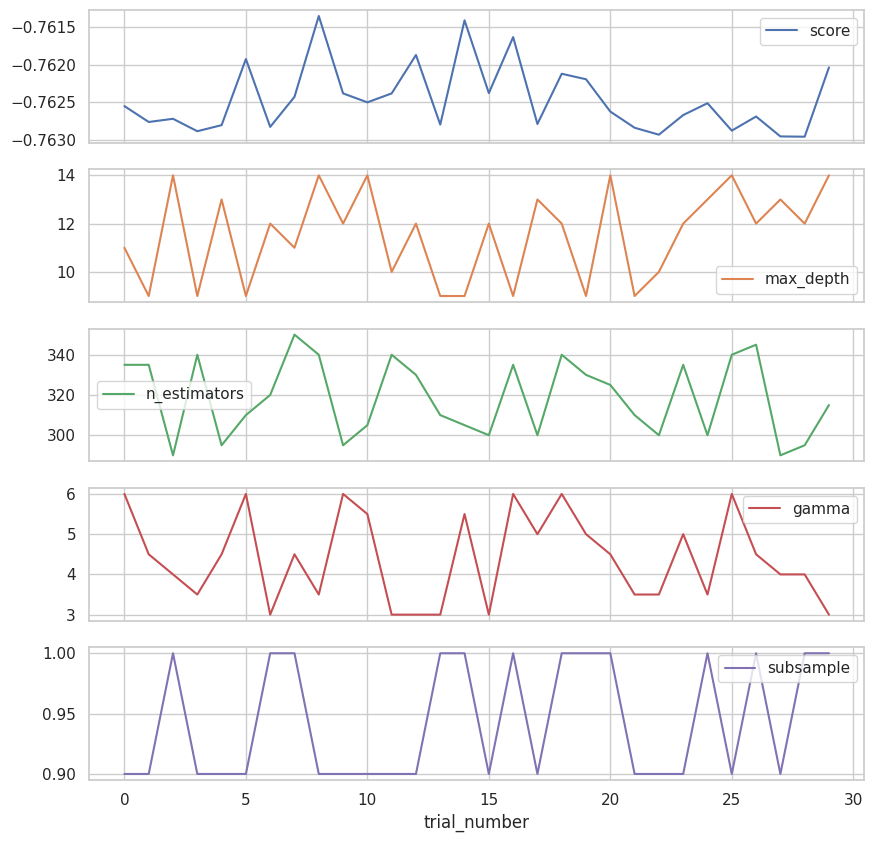

In [65]:
results_adapted[['score','max_depth','n_estimators','gamma','subsample']].plot(subplots=True,figsize=(10,10))